In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [4]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [5]:
# Load config file, double check your parameters are correct

#yaml_file_path = os.path.join(dir_config, "chile_config.yaml")
#config_params = g_utils.get_yaml_values(yaml_file_path)

#country_name = config_params['country_name']
#ssp_input_file_name = config_params['ssp_input_file_name']
#ssp_transformation_cw = config_params['ssp_transformation_cw']
#energy_model_flag = config_params['energy_model_flag']


In [6]:
import yaml, os

yaml_file_path = os.path.join(dir_config, "chile_config.yaml")
with open(yaml_file_path, "r", encoding="utf-8") as f:
    config_params = yaml.safe_load(f)

country_name = config_params["country_name"]
ssp_input_file_name = config_params["ssp_input_file_name"]
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']


In [7]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [8]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [9]:
?g_utils.check_frac_groups

Signature: g_utils.check_frac_groups(ssp_input_df, frac_vars_mapping_file_path)
Docstring:
Checks if the sum of fractional groups in the input DataFrame is within the range [0, 1].
This function reads a mapping file to identify subgroups of columns in the input DataFrame.
For each subgroup, it calculates the row-wise sum of the columns and checks if the sums are within the range [0, 1].
If any row sum is outside this range, a message is printed indicating the issue.
Args:
    ssp_input_df (pd.DataFrame): The input DataFrame containing the data to be checked.
    frac_vars_mapping_file_path (str): The file path to the Excel file containing the mapping of fractional variables.
Returns:
    None
File:      /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/ssp_transformations_handler/GeneralUtils.py
Type:      function

In [10]:
# Check frac variables in df_inputs_raw
g_utils.check_frac_groups(df_inputs_raw, os.path.join(dir_misc, "energy_frac_vars.xlsx"))

Row sums for frac_enfu_fuel_demand are not in range the min is 4.665921802747663 and the max is 7.3874052527617335. Please check the data.
Row sums for frac_trns_fuelmix_powered are not in range the min is 0.9999999999999999 and the max is 1.0000000000000002. Please check the data.


In [11]:
g_utils.check_individual_frac_vars(df_inputs_raw)

Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_wind are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_ocean are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_geothermal are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal_ccs are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biomass are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_produc

In [12]:
df_inputs_raw[[col for col in df_inputs_raw.columns if 'frac_trns_fuelmix_rail_passenger' in col]].head()

,frac_trns_fuelmix_rail_passenger_electricity,frac_trns_fuelmix_rail_passenger_natural_gas,frac_trns_fuelmix_rail_passenger_diesel,frac_trns_fuelmix_rail_passenger_hydrogen
0,0.517241,0.0,0.482759,0.0
1,0.515217,0.0,0.484783,0.0
2,0.508621,0.0,0.491379,0.0
3,0.516060,0.0,0.483940,0.0
4,0.522293,0.0,0.477707,0.0


In [13]:
df_inputs_raw.drop(columns=['frac_trns_fuelmix_rail_passenger_diesel'], inplace=True)
df_inputs_raw.rename(columns={'frac_trns_fuelmix_rail_passenger_diesel.1':'frac_trns_fuelmix_rail_passenger_diesel'}, inplace=True)
df_inputs_raw[[col for col in df_inputs_raw.columns if 'frac_trns_fuelmix_rail_passenger' in col]].head()

,frac_trns_fuelmix_rail_passenger_electricity,frac_trns_fuelmix_rail_passenger_natural_gas,frac_trns_fuelmix_rail_passenger_hydrogen
0,0.517241,0.0,0.0
1,0.515217,0.0,0.0
2,0.508621,0.0,0.0
3,0.516060,0.0,0.0
4,0.522293,0.0,0.0


In [14]:
g_utils.check_frac_groups(df_inputs_raw, os.path.join(dir_misc, "energy_frac_vars.xlsx"))

Row sums for frac_enfu_fuel_demand are not in range the min is 4.665921802747663 and the max is 7.3874052527617335. Please check the data.
Row sums for frac_trns_fuelmix_powered are not in range the min is 0.9999999999999999 and the max is 1.0000000000000002. Please check the data.


In [15]:
df_inputs_raw[[col for col in df_inputs_raw.columns if 'consumpinit_inen_energy_tj_per_tonne_production_cement' in col]].head()

,consumpinit_inen_energy_tj_per_tonne_production_cement
0,0.002118
1,0.002126
2,0.002139
3,0.001789
4,0.001756


In [16]:
df_inputs_raw.drop(columns=['consumpinit_inen_energy_tj_per_tonne_production_cement'], inplace=True)
df_inputs_raw.rename(columns={'consumpinit_inen_energy_tj_per_tonne_production_cement.1':'consumpinit_inen_energy_tj_per_tonne_production_cement'}, inplace=True)
df_inputs_raw[[col for col in df_inputs_raw.columns if 'consumpinit_inen_energy_tj_per_tonne_production_cement' in col]].head()

""
0
1
2
3
4


In [17]:
df_inputs_example.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [18]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df_example but not in df_input: {'frac_lndu_receiving_fertilizer_grasslands', 'factor_lndu_soil_management_unimproved_grasslands', 'frac_lndu_improved_grasslands', 'consumpinit_inen_energy_tj_per_tonne_production_cement', 'ef_soil_c_cultivated_organic_temperate_crop_grass_tonne_per_ha', 'factor_lndu_soil_management_supremum_grasslands', 'frac_lndu_proportion_grasslands_pasture', 'strategy_id', 'frac_lndu_increasing_net_exports_met_grasslands', 'frac_lndu_increasing_net_imports_met_grasslands', 'ef_soil_c_cultivated_organic_tropical_crop_grass_tonne_per_ha', 'frac_trns_fuelmix_rail_passenger_diesel'}
Columns in df_input but not in df_example: {'pij_lndu_pastures_to_forests_mangroves', 'ef_lndu_conv_forests_primary_to_flooded_gg_co2_ha', 'frac_lndu_soil_mineral_flooded', 'frac_lndu_utilization_rate_pastures', 'frac_lndu_initial_with_drained_organic_soils_pastures', 'pij_lndu_wetlands_to_pastures', 'factor_lndu_soil_management_supremum_pastures', 'ef_lndu_conv_shrublands_to_shr

In [19]:
# Check for duplicated col names
duplicated_columns = df_inputs_raw.columns[df_inputs_raw.columns.duplicated()].tolist()
print(duplicated_columns)

[]


In [20]:
help(g_utils.remove_additional_cols)

Help on function remove_additional_cols in module ssp_transformations_handler.GeneralUtils:

remove_additional_cols(df_example, df_input)
    Remove columns from df_input that are not present in df_example.
    Parameters:
    df_example (pandas.DataFrame): The reference DataFrame containing the desired columns.
    df_input (pandas.DataFrame): The DataFrame from which additional columns will be removed.
    Returns:
    pandas.DataFrame: A DataFrame with only the columns present in df_example.



In [21]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
# df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw_complete.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,year,frac_agrc_vegetables_and_vines_cl2_wet,frac_agrc_pulses_cl2_wet,frac_agrc_no_till_cereals,frac_agrc_sugar_cane_cl1_tropical,yf_agrc_herbs_and_other_perennial_crops_tonne_ha,frac_agrc_herbs_and_other_perennial_crops_cl2_dry,frac_agrc_no_till_pulses,frac_agrc_herbs_and_other_perennial_crops_cl1_tropical,yf_agrc_vegetables_and_vines_tonne_ha,...,factor_lndu_soil_management_supremum_grasslands,factor_lndu_soil_management_unimproved_grasslands,frac_lndu_improved_grasslands,frac_lndu_increasing_net_exports_met_grasslands,frac_lndu_increasing_net_imports_met_grasslands,frac_lndu_receiving_fertilizer_grasslands,strategy_id,frac_lndu_proportion_grasslands_pasture,consumpinit_inen_energy_tj_per_tonne_production_cement,frac_trns_fuelmix_rail_passenger_diesel
0,2015,0.275055,0.275055,0.143776,0.000109,0.995331,0.724945,0.143776,0.000109,26.756008,...,1.1567,0.9,0.125,1.0,1.0,0.4,0,0.335252,0.000814,0.482759
1,2016,0.275055,0.275055,0.143776,0.000109,1.142434,0.724945,0.143776,0.000109,27.609474,...,1.1567,0.9,0.125,1.0,1.0,0.4,0,0.335252,0.000718,0.484783
2,2017,0.275055,0.275055,0.143776,0.000109,0.921917,0.724945,0.143776,0.000109,28.851356,...,1.1567,0.9,0.125,1.0,1.0,0.4,0,0.335252,0.000631,0.491379
3,2018,0.275055,0.275055,0.143776,0.000109,0.971025,0.724945,0.143776,0.000109,28.463518,...,1.1567,0.9,0.125,1.0,1.0,0.4,0,0.335252,0.000730,0.483940
4,2019,0.275055,0.275055,0.143776,0.000109,0.939223,0.724945,0.143776,0.000109,29.381269,...,1.1567,0.9,0.125,1.0,1.0,0.4,0,0.335252,0.000757,0.477707


In [22]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: {'pij_lndu_pastures_to_forests_mangroves', 'ef_lndu_conv_forests_primary_to_flooded_gg_co2_ha', 'frac_lndu_soil_mineral_flooded', 'frac_lndu_utilization_rate_pastures', 'frac_lndu_initial_with_drained_organic_soils_pastures', 'pij_lndu_wetlands_to_pastures', 'factor_lndu_soil_management_supremum_pastures', 'ef_lndu_conv_shrublands_to_shrublands_gg_co2_ha', 'ef_lndu_conv_shrublands_to_forests_secondary_gg_co2_ha', 'ef_lndu_conv_croplands_to_flooded_gg_co2_ha', 'pij_lndu_forests_secondary_to_pastures', 'pij_lndu_pastures_to_flooded', 'pij_lndu_pastures_to_wetlands', 'ef_lndu_conv_pastures_to_wetlands_gg_co2_ha', 'pij_lndu_pastures_to_shrublands', 'ef_lndu_conv_wetlands_to_flooded_gg_co2_ha', 'energydensity_gravimetric_enfu_gj_per_tonne_fuel_natural_gas', 'area_lndu_supremum_grasslands_ha', 'pij_lndu_forests_primary_to_shrublands', 'ef_lndu_conv_grasslands_to_pastures_gg_co2_ha', 'ef_lndu_conv_fore

In [23]:
df_inputs_raw_complete[[col for col in df_inputs_raw_complete.columns if 'nemomod_entc_variable_cost_pp_waste_incineration' in col]].head()

,nemomod_entc_variable_cost_pp_waste_incineration_usd_per_mwh
0,3.22
1,3.22
2,3.22
3,3.22
4,3.22


In [24]:
df_inputs_example[[col for col in df_inputs_example.columns if 'nemomod_entc_variable_cost_pp_waste_incineration' in col]].head()

,nemomod_entc_variable_cost_pp_waste_incineration_usd_per_mwh
0,3.22
1,3.22
2,3.22
3,3.22
4,3.22


In [25]:
# Checking if there are any columns with null values in it
columns_with_na = df_inputs_raw_complete.columns[df_inputs_raw_complete.isna().any()].tolist()

print(columns_with_na)

[]


In [26]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

0    chile
1    chile
2    chile
3    chile
4    chile
Name: region, dtype: object

In [27]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    chile
1    chile
2    chile
3    chile
4    chile
Name: region, dtype: object

In [28]:
g_utils.check_frac_groups(df_inputs_raw_complete, os.path.join(dir_misc, "energy_frac_vars.xlsx"))

Row sums for frac_enfu_fuel_demand are not in range the min is 4.665921802747663 and the max is 7.3874052527617335. Please check the data.
Row sums for frac_trns_fuelmix_powered are not in range the min is 0.9999999999999999 and the max is 1.0000000000000002. Please check the data.


In [29]:
g_utils.check_individual_frac_vars(df_inputs_raw_complete)

Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_wind are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_ocean are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_geothermal are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal_ccs are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biomass are not within the range [0, 1]. Please check the data.
Values in column frac_entc_max_elec_produc

#  Let's try building transformations using this


In [30]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [31]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /Users/mfef/Documents/ssp_cl/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [32]:
?TransformationYamlProcessor

Init signature:
TransformationYamlProcessor(
    scenario_mapping_excel_path,
    yaml_dir_path,
    sheet_name='yaml',
)
Docstring:     
TransformationYamlProcessor is a class designed to handle the processing of YAML files based on scenario mappings provided in an Excel file. It provides methods to load scenario mappings, retrieve strategy names, load YAML data, save modified YAML files, and process YAML files according to specified transformations.
Methods:
    __init__(self, scenario_mapping_excel_path, yaml_dir_path, sheet_name='yaml'):
        Initializes the TransformationYamlProcessor class with the given parameters.
    load_scenario_mapping_excel(self):
    load_yaml_data(self, yaml_file_path):
    get_strategy_names(self):
    save_yaml_file(self, yaml_content, yaml_name, column, transformation_code, subsector, transformation_name, scalar_val):
    get_transformations_per_strategy_dict(self):
    process_yaml_files(self):
Init docstring:
Initializes the TransformationUtils c

In [33]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=dir_transformations)

/Users/mfef/Documents/ssp_cl/ssp_modeling/scenario_mapping/ssp_Chile_transformation_2025_08_20.xlsx
Error loading Excel file: [Errno 2] No such file or directory: '/Users/mfef/Documents/ssp_cl/ssp_modeling/scenario_mapping/ssp_Chile_transformation_2025_08_20.xlsx'


In [34]:
# This creates transformation yaml files for each strategy in the excel file
excel_yaml_handler.process_yaml_files()

ValueError: No data found in the mapping excel file.

In [35]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

AttributeError: 'NoneType' object has no attribute 'columns'

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [36]:
?StrategyCSVHandler

Init signature:
StrategyCSVHandler(
    csv_file_path,
    yaml_dir_path,
    yaml_mapping_file,
    transformation_per_strategy_dict,
)
Docstring:     
A class to handle strategy CSV files and YAML mappings for transformations.
Methods:
    __init__(csv_file_path, yaml_dir_path, yaml_mapping_file, transformation_per_strategy_dict):
        Initializes the StrategyCSVHandler class with the given parameters.
    load_strategy_definitions_csv():
    load_yaml_mapping():
    get_strategy_id(strategy_group):
    get_strategy_code(strategy_group, strategy_name):
    get_transformation_specification(yaml_file_suffix):
    save_csv():
    add_strategy(strategy_group, description, yaml_file_suffix):
Init docstring:
Initializes the TransformationUtils class with the given parameters.

Args:
    csv_file_path (str): The file path to the CSV file containing strategy definitions.
    yaml_dir_path (str): The directory path where YAML files are located.
    yaml_mapping_file (str): The file name of

In [37]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M8 Economia Circular', yaml_file_suffix='M8_EC')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M7 Eficiencia Energetica', yaml_file_suffix='M7_EE')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M6 Fomento al Transporte Ferroviario', yaml_file_suffix='M6_TF')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M5 Estrategia de Trabajo Remoto', yaml_file_suffix='M5_TR')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M4 Pacto de Glasgow por la Electromovilidad', yaml_file_suffix='M4_EV')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M3 Estrategia de Carbono Azul', yaml_file_suffix='M3_CA')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M2 Nuevas Areas Naturales Protegidas', yaml_file_suffix='M2_ANP')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico Programa Sembrando Vida', yaml_file_suffix='SV')


NameError: name 'transformation_per_strategy_dict' is not defined

In [38]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010]

### We finished adding new transformation files and strategies so lets load them back

In [39]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [40]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /Users/mfef/Documents/ssp_cl/ssp_modeling/transformations initialized in 1.83 seconds


In [41]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
72,6006,PFLO:M5_TR,M5_TR,Mexico M5 Estrategia de Trabajo Remoto,TX:TRDE:DEC_DEMAND_STRATEGY_M5_TR|TX:TRNS:SHIF...,0
73,6007,PFLO:M4_EV,M4_EV,Mexico M4 Pacto de Glasgow por la Electromovil...,TX:TRNS:SHIFT_FUEL_LIGHT_DUTY_STRATEGY_M4_EV|T...,0
74,6008,PFLO:M3_CA,M3_CA,Mexico M3 Estrategia de Carbono Azul,TX:LNDU:DEC_DEFORESTATION_STRATEGY_M3_CA,0
75,6009,PFLO:M2_ANP,M2_ANP,Mexico M2 Nuevas Areas Naturales Protegidas,TX:LNDU:DEC_DEFORESTATION_STRATEGY_M2_ANP|TX:L...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [42]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 6003 with input shape (36, 2396)
strat 6003 with output shape (36, 2396)
here = 6003
starting strat 6004 with input shape (36, 2396)
strat 6004 with output shape (36, 2396)
here = 6004
starting strat 6005 with input shape (36, 2396)
strat 6005 with output shape (36, 2396)
here = 6005
starting strat 6006 with input shape (36, 2396)
strat 6006 with output shape (36, 2396)
here = 6006
starting strat 6007 with input shape (36, 2396)
strat 6007 with output shape (36, 2396)
here = 6007
starting strat 6008 with input shape (36, 2396)
strat 6008 with output shape (36, 2396)
here = 6008
starting strat 6009 with input shape (36, 2396)
strat 6009 with output shape (36, 2396)
here = 6009
starting strat 6010 with input shape (36, 2396)
strat 6010 with output shape (36, 2396)
here = 6010


0

# Finally, load SISEPUEDE so that we can run it

In [43]:
country_name

'chile'

In [44]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-08-20 21:34:25,088 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-08-20 21:34:25,090 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-08-20 21:34:25,090 - INFO - 	Setting export engine to 'csv'.
2025-08-20 21:34:25,091 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-08-20 21:34:25,091 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-08-20 21:34:25,091 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-08-20 21:34:25,092 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-08-20 21:34:25,092 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-08-20 21:34:25,092 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-08-20 21:34:25,093 - WARNING - No index fi

[juliapkg] Found dependencies: /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/julia/pyjuliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.11.6 to /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/julia/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/mac/a

  Installing known registries into `~/.julia`
       Added `General` registry to ~/.julia/registries
     Cloning git-repo `https://github.com/sei-international/NemoMod.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed MicroMamba ────────────────── v0.1.14
   Installed DiffRules ─────────────────── v1.15.1
   Installed IrrationalConstants ───────── v0.2.4
   Installed Crayons ───────────────────── v4.1.1
   Installed Scratch ───────────────────── v1.3.0
   Installed PrettyTables ──────────────── v2.4.0
   Installed MutableArithmetics ────────── v1.6.4
   Installed SQLite ────────────────────── v1.6.1
   Installed JSON3 ─────────────────────── v1.14.3
   Installed GLPK_jll ──────────────────── v5.0.1+1
   Installed JSON ──────────────────────── v0.21.4
   Installed Preferences ───────────────── v1.5.0
   Installed Clp_jll ───────────────────── v100.1700.700+1
   Installed MUMPS_seq_jll ─────────────── v500.800.0+0
   Instal

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1780.7 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-08-20 21:40:21,466 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-08-20 21:40:21,486 - INFO - Successfully initialized SISEPUEDEModels.
2025-08-20 21:40:21,494 - INFO - Table ANALYSIS_METADATA successfully written to /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packag

In [45]:
not(energy_model_flag)

False

In [46]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-08-20 21:40:44,165 - INFO - 
***	STARTING REGION chile	***

2025-08-20 21:40:46,009 - INFO - Trying run primary_id = 0 in region chile
2025-08-20 21:40:46,010 - INFO - Running AFOLU model
2025-08-20 21:40:46,125 - INFO - AFOLU model run successfully completed
2025-08-20 21:40:46,125 - INFO - Running CircularEconomy model
2025-08-20 21:40:46,155 - INFO - CircularEconomy model run successfully completed
2025-08-20 21:40:46,156 - INFO - Running IPPU model
2025-08-20 21:40:46,206 - INFO - IPPU model run successfully completed
2025-08-20 21:40:46,206 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-20 21:40:46,219 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-20 21:40:46,280 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-20 21:40:46,280 - INFO - Running Energy model (Electricity and Fuel Production: trying to 

2025-20-Aug 21:40:46.696 Opened SQLite database at /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-20-Aug 21:40:46.872 Added NEMO structure to SQLite database at /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-20-Aug 21:40:55.623 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
┌ Warning: Results that will be saved to database are for a suboptimal solution. See this function's return value for more information.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6170
2025-08-20 21:56:15,981 - INFO - NemoMod ran successfully with the following status: TIME_LIMIT
2025-08-20 21:56:15,993 - INFO - EnergyProduction model run successfully completed
2025-08-20 21:56:15,994 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 21:56:16,020 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-20 21:56:16,020 - INFO - Appending Socioeconomic outputs
2025-08-20 21:56:16,026 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 21:56:16,029 - INFO - Model run for primary_id = 0 successfully completed in 930.02 sec

2025-20-Aug 21:56:15.829 Finished modeling scenario.


2025-08-20 21:56:16,059 - INFO - Trying run primary_id = 69069 in region chile
2025-08-20 21:56:16,060 - INFO - Running AFOLU model
2025-08-20 21:56:16,172 - INFO - AFOLU model run successfully completed
2025-08-20 21:56:16,172 - INFO - Running CircularEconomy model
2025-08-20 21:56:16,202 - INFO - CircularEconomy model run successfully completed
2025-08-20 21:56:16,202 - INFO - Running IPPU model
2025-08-20 21:56:16,250 - INFO - IPPU model run successfully completed
2025-08-20 21:56:16,250 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-20 21:56:16,261 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-20 21:56:16,318 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-20 21:56:16,318 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-20-Aug 21:56:17.024 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-20 21:58:12,010 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-20 21:58:12,017 - INFO - EnergyProduction model run successfully completed
2025-08-20 21:58:12,017 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 21:58:12,041 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-20 21:58:12,042 - INFO - Appending Socioeconomic outputs
2025-08-20 21:58:12,047 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 21:58:12,050 - INFO - Model run for primary_id = 69069 successfully completed in 115.99 seconds (n_tries = 1).
2025-08-20 21:58:12,053 - INFO - Trying run primary_id = 70070 in region chile
2025-08-20 21:58:12,053 - INFO - Running AFOLU model


2025-20-Aug 21:58:11.911 Finished modeling scenario.


2025-08-20 21:58:12,163 - INFO - AFOLU model run successfully completed
2025-08-20 21:58:12,163 - INFO - Running CircularEconomy model
2025-08-20 21:58:12,192 - INFO - CircularEconomy model run successfully completed
2025-08-20 21:58:12,192 - INFO - Running IPPU model
2025-08-20 21:58:12,239 - INFO - IPPU model run successfully completed
2025-08-20 21:58:12,239 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-20 21:58:12,251 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-20 21:58:12,306 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-20 21:58:12,307 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-20-Aug 21:58:12.993 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-20 22:17:30,167 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable
2025-08-20 22:17:30,196 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 22:17:30,266 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-08-20 22:17:30,267 - INFO - Appending Socioeconomic outputs
2025-08-20 22:17:30,273 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 22:17:30,289 - INFO - Model run for primary_id = 70070 successfully completed in 1158.24 seconds (n_tries = 1).
2025-08-20 22:17:30,300 - INFO - Trying run primary_id = 71071 in region chile
2025-08-20 22:17:30,301 - INFO - Running AFOLU model


2025-20-Aug 22:17:30.139 Solver did not find a solution for model. No results will be saved to database.
2025-20-Aug 22:17:30.146 Finished modeling scenario.


2025-08-20 22:17:30,423 - INFO - AFOLU model run successfully completed
2025-08-20 22:17:30,423 - INFO - Running CircularEconomy model
2025-08-20 22:17:30,455 - INFO - CircularEconomy model run successfully completed
2025-08-20 22:17:30,456 - INFO - Running IPPU model
2025-08-20 22:17:30,507 - INFO - IPPU model run successfully completed
2025-08-20 22:17:30,508 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-20 22:17:30,520 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-20 22:17:30,579 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-20 22:17:30,579 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-20-Aug 22:17:31.545 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-20 22:20:02,645 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-20 22:20:02,663 - INFO - EnergyProduction model run successfully completed
2025-08-20 22:20:02,664 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 22:20:02,688 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-20 22:20:02,689 - INFO - Appending Socioeconomic outputs
2025-08-20 22:20:02,694 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 22:20:02,697 - INFO - Model run for primary_id = 71071 successfully completed in 152.4 seconds (n_tries = 1).
2025-08-20 22:20:02,713 - INFO - Trying run primary_id = 72072 in region chile
2025-08-20 22:20:02,713 - INFO - Running AFOLU model


2025-20-Aug 22:20:02.517 Finished modeling scenario.


2025-08-20 22:20:02,828 - INFO - AFOLU model run successfully completed
2025-08-20 22:20:02,829 - INFO - Running CircularEconomy model
2025-08-20 22:20:02,859 - INFO - CircularEconomy model run successfully completed
2025-08-20 22:20:02,859 - INFO - Running IPPU model
2025-08-20 22:20:02,906 - INFO - IPPU model run successfully completed
2025-08-20 22:20:02,907 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-20 22:20:02,918 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-20 22:20:02,974 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-20 22:20:02,974 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-20-Aug 22:20:03.671 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-20 22:22:04,316 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-20 22:22:04,324 - INFO - EnergyProduction model run successfully completed
2025-08-20 22:22:04,325 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 22:22:04,349 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-20 22:22:04,349 - INFO - Appending Socioeconomic outputs
2025-08-20 22:22:04,355 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 22:22:04,358 - INFO - Model run for primary_id = 72072 successfully completed in 121.64 seconds (n_tries = 1).
2025-08-20 22:22:04,362 - INFO - Trying run primary_id = 73073 in region chile
2025-08-20 22:22:04,363 - INFO - Running AFOLU model


2025-20-Aug 22:22:04.211 Finished modeling scenario.


2025-08-20 22:22:04,472 - INFO - AFOLU model run successfully completed
2025-08-20 22:22:04,473 - INFO - Running CircularEconomy model
2025-08-20 22:22:04,501 - INFO - CircularEconomy model run successfully completed
2025-08-20 22:22:04,502 - INFO - Running IPPU model
2025-08-20 22:22:04,549 - INFO - IPPU model run successfully completed
2025-08-20 22:22:04,549 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-20 22:22:04,561 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-20 22:22:04,622 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-20 22:22:04,623 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-20-Aug 22:22:05.333 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-20 22:24:06,943 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-20 22:24:06,955 - INFO - EnergyProduction model run successfully completed
2025-08-20 22:24:06,956 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 22:24:06,983 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-20 22:24:06,983 - INFO - Appending Socioeconomic outputs
2025-08-20 22:24:06,989 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 22:24:06,994 - INFO - Model run for primary_id = 73073 successfully completed in 122.63 seconds (n_tries = 1).
2025-08-20 22:24:07,013 - INFO - Trying run primary_id = 74074 in region chile
2025-08-20 22:24:07,013 - INFO - Running AFOLU model


2025-20-Aug 22:24:06.820 Finished modeling scenario.


2025-08-20 22:24:07,134 - INFO - AFOLU model run successfully completed
2025-08-20 22:24:07,134 - INFO - Running CircularEconomy model
2025-08-20 22:24:07,174 - INFO - CircularEconomy model run successfully completed
2025-08-20 22:24:07,174 - INFO - Running IPPU model
2025-08-20 22:24:07,222 - INFO - IPPU model run successfully completed
2025-08-20 22:24:07,223 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-20 22:24:07,235 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-20 22:24:07,290 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-20 22:24:07,291 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-20-Aug 22:24:08.276 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2025-20-Aug 22:27:13.063 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-20 22:27:13,197 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-20 22:27:13,207 - INFO - EnergyProduction model run successfully completed
2025-08-20 22:27:13,208 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 22:27:13,243 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-20 22:27:13,243 - INFO - Appending Socioeconomic outputs
2025-08-20 22:27:13,249 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 22:27:13,251 - INFO - Model run for primary_id = 74074 successfully completed in 186.24 seconds (n_tries = 1).
2025-08-20 22:27:13,271 - INFO - Trying run primary_id = 75075 in region chile
2025-08-20 22:27:13,272 - INFO - Running AFOLU model
2025-08-20 22:27:13,381 - INFO - AFOLU model run successfull

2025-20-Aug 22:27:14.221 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-20 22:34:21,072 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable
2025-08-20 22:34:21,082 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 22:34:21,106 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-08-20 22:34:21,107 - INFO - Appending Socioeconomic outputs
2025-08-20 22:34:21,113 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 22:34:21,116 - INFO - Model run for primary_id = 75075 successfully completed in 427.84 seconds (n_tries = 1).
2025-08-20 22:34:21,134 - INFO - Trying run primary_id = 76076 in region chile
2025-08-20 22:34:21,135 - INFO - Running AFOLU model
2025-08-20 22:34:21,245 - INFO - AFOLU model run successfully completed
2025-08-20 22:34:2

2025-20-Aug 22:34:21.054 Solver did not find a solution for model. No results will be saved to database.
2025-20-Aug 22:34:21.060 Finished modeling scenario.


2025-08-20 22:34:21,275 - INFO - CircularEconomy model run successfully completed
2025-08-20 22:34:21,275 - INFO - Running IPPU model
2025-08-20 22:34:21,361 - INFO - IPPU model run successfully completed
2025-08-20 22:34:21,361 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-20 22:34:21,373 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-20 22:34:21,430 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-20 22:34:21,431 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-20-Aug 22:34:22.131 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-20 22:39:07,193 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable
2025-08-20 22:39:07,209 - INFO - Running Energy (Fugitive Emissions)
2025-08-20 22:39:07,242 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-08-20 22:39:07,242 - INFO - Appending Socioeconomic outputs
2025-08-20 22:39:07,248 - INFO - Socioeconomic outputs successfully appended.
2025-08-20 22:39:07,251 - INFO - Model run for primary_id = 76076 successfully completed in 286.12 seconds (n_tries = 1).
2025-08-20 22:39:07,253 - INFO - 
***	 REGION chile COMPLETE	***



2025-20-Aug 22:39:07.170 Solver did not find a solution for model. No results will be saved to database.
2025-20-Aug 22:39:07.181 Finished modeling scenario.


2025-08-20 22:39:07,489 - INFO - Table MODEL_OUTPUT successfully written to /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-08-20T21;34;24.713468/sisepuede_run_2025-08-20T21;34;24.713468_output_database/MODEL_OUTPUT.csv.
2025-08-20 22:39:07,492 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-08-20T21;34;24.713468/sisepuede_run_2025-08-20T21;34;24.713468_output_database/ATTRIBUTE_PRIMARY.csv.
2025-08-20 22:39:07,764 - INFO - Table MODEL_INPUT successfully written to /opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-08-20T21;34;24.713468/sisepuede_run_2025-08-20T21;34;24.713468_output_database/MODEL_INPUT.csv.


{'chile': [0, 69069, 70070, 71071, 72072, 73073, 74074, 75075, 76076]}

In [47]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [48]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

## Some testing for Croatia (you can delete this section for a new country)

In [49]:
df_out.head()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,chile,0,0.0,842592.410648,54311.959794,644929.762103,0.0,72815.871374,309826.983216,...,6.863215e+06,0.0,0.0,669362.426433,0.0,186088.939511,0.0,0.0,7.306054e+06,2.476790e+06
1,0,chile,1,0.0,866258.024311,58656.018895,615439.455835,0.0,36173.269793,307355.723911,...,7.275315e+06,2388.0,1960.0,681220.973804,1108.0,190850.661207,2736.0,2449.0,7.308243e+06,2.528370e+06
2,0,chile,2,0.0,875427.814953,61598.002837,597873.664149,0.0,18054.806024,319826.679039,...,7.289675e+06,2388.0,1960.0,664144.300438,1108.0,183546.336585,2736.0,2449.0,7.492856e+06,2.597790e+06
3,0,chile,3,0.0,890861.573108,63364.395802,593255.817370,0.0,8951.454817,321863.968689,...,7.243226e+06,2388.0,1960.0,695559.192979,1108.0,192027.304720,2736.0,2449.0,7.630150e+06,2.578499e+06
4,0,chile,4,0.0,894115.080109,63708.693530,602672.394550,0.0,4421.351418,336246.320154,...,7.143918e+06,2388.0,1960.0,678045.354719,1108.0,196231.750415,2736.0,2449.0,7.586960e+06,2.641405e+06


In [50]:
# Checking we've got an output df
df_out[[col for col in df_out.columns if 'subsector' in col]].head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
0,1.499134,0.0,17.522888,3.172732,-143.594597,39.681572,67.365916,17.387184,1.961681,11.679130,...,22.445201,0.000412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.378155,0.0,17.472418,3.509156,-144.502626,38.529881,69.368828,28.016198,1.960677,11.618863,...,23.071721,0.000369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.333026,0.0,16.227754,2.793369,-145.850793,41.900466,72.540656,22.731859,1.960528,11.579957,...,22.850278,0.000263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.315712,0.0,17.198496,3.435436,-146.508652,41.865714,75.348955,13.781832,1.973987,11.582767,...,24.048084,0.000217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.315988,0.0,16.977884,3.463801,-147.867796,41.374694,76.344032,24.764320,1.970028,11.543354,...,24.067240,0.000220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df_out[[col for col in df_out.columns if 'subsector' in col]].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
319,1.579537,0.0,NaN,NaN,-165.036973,62.143718,99.455104,76.190860,1.895127,10.907160,...,92.392096,0.000225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320,1.583621,0.0,NaN,NaN,-165.707586,63.206237,100.673413,76.594331,1.900875,10.889303,...,97.492093,0.000230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
321,1.586706,0.0,NaN,NaN,-166.388124,64.263025,101.886762,77.004179,1.906337,10.870433,...,102.753644,0.000234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
322,1.588722,0.0,NaN,NaN,-167.081718,65.316475,103.097900,77.421974,1.911446,10.849603,...,108.189699,0.000239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,1.589549,0.0,NaN,NaN,-167.792029,66.362603,104.302266,77.857602,1.916098,10.825861,...,113.780557,0.000243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
cement_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_cement_tonne' in col]]
cement_df['year'] = cement_df['time_period'] + 2015
cement_df[cement_df.primary_id == 0]

,primary_id,time_period,prod_ippu_cement_tonne,year
0,0,0,4.320000e+06,2015
1,0,1,4.324310e+06,2016
2,0,2,4.327654e+06,2017
3,0,3,4.337487e+06,2018
4,0,4,4.339326e+06,2019
5,0,5,4.324139e+06,2020
6,0,6,4.353044e+06,2021
7,0,7,4.359089e+06,2022
8,0,8,4.359633e+06,2023
9,0,9,4.364556e+06,2024


In [53]:
mining_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_mining_tonne' in col]]
mining_df['year'] = mining_df['time_period'] + 2015
mining_df[mining_df.primary_id == 0]

,primary_id,time_period,prod_ippu_mining_tonne,year
0,0,0,6.212481e+08,2015
1,0,1,6.266906e+08,2016
2,0,2,6.309451e+08,2017
3,0,3,6.435320e+08,2018
4,0,4,6.459270e+08,2019
5,0,5,6.260790e+08,2020
6,0,6,6.628241e+08,2021
7,0,7,6.709057e+08,2022
8,0,8,6.716403e+08,2023
9,0,9,6.782996e+08,2024


In [54]:
df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.5

In [55]:
df_in['lndu_reallocation_factor'].mean()

0.3333333333333333

In [56]:
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp'].head()

0    0.056947
1    0.056947
2    0.056947
3    0.056947
4    0.056947
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

In [57]:
df_in[['primary_id', 'time_period', 'elasticity_ippu_cement_production_to_gdp']].head()

,primary_id,time_period,elasticity_ippu_cement_production_to_gdp
0,0,0,0.056947
1,0,1,0.056947
2,0,2,0.056947
3,0,3,0.056947
4,0,4,0.056947


In [58]:
[col for col in df_out.columns if 'lvst' in col]

['demand_lvst_buffalo',
 'demand_lvst_cattle_dairy',
 'demand_lvst_cattle_nondairy',
 'demand_lvst_chickens',
 'demand_lvst_goats',
 'demand_lvst_horses',
 'demand_lvst_mules',
 'demand_lvst_pigs',
 'demand_lvst_sheep',
 'emission_co2e_ch4_lvst_entferm_buffalo',
 'emission_co2e_ch4_lvst_entferm_cattle_dairy',
 'emission_co2e_ch4_lvst_entferm_cattle_nondairy',
 'emission_co2e_ch4_lvst_entferm_chickens',
 'emission_co2e_ch4_lvst_entferm_goats',
 'emission_co2e_ch4_lvst_entferm_horses',
 'emission_co2e_ch4_lvst_entferm_mules',
 'emission_co2e_ch4_lvst_entferm_pigs',
 'emission_co2e_ch4_lvst_entferm_sheep',
 'emission_co2e_subsector_total_lvst',
 'exportsadj_lvst_buffalo',
 'exportsadj_lvst_cattle_dairy',
 'exportsadj_lvst_cattle_nondairy',
 'exportsadj_lvst_chickens',
 'exportsadj_lvst_goats',
 'exportsadj_lvst_horses',
 'exportsadj_lvst_mules',
 'exportsadj_lvst_pigs',
 'exportsadj_lvst_sheep',
 'importssadj_lvst_buffalo',
 'importssadj_lvst_cattle_dairy',
 'importssadj_lvst_cattle_nonda

In [59]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'demand_lvst' in col]].head(36)

,primary_id,time_period,demand_lvst_buffalo,demand_lvst_cattle_dairy,demand_lvst_cattle_nondairy,demand_lvst_chickens,demand_lvst_goats,demand_lvst_horses,demand_lvst_mules,demand_lvst_pigs,demand_lvst_sheep
0,0,0,0.0,3.101899e+06,3.305146e+06,1.115404e+08,482587.738191,376004.132253,29075.640608,3.449413e+06,2.723119e+06
1,0,1,0.0,3.114673e+06,3.321081e+06,1.121982e+08,484975.187410,377863.810377,29220.451457,3.466044e+06,2.736587e+06
2,0,2,0.0,3.126946e+06,3.333740e+06,1.126036e+08,486812.275059,379296.074536,29330.597320,3.479256e+06,2.746954e+06
3,0,3,0.0,3.155542e+06,3.378409e+06,1.148568e+08,493709.089164,384669.780957,29745.566086,3.525874e+06,2.785873e+06
4,0,4,0.0,3.157237e+06,3.377779e+06,1.147053e+08,493551.578679,384546.769441,29736.202908,3.525218e+06,2.784985e+06
5,0,5,0.0,3.105847e+06,3.284830e+06,1.095113e+08,478942.905595,373164.898864,28857.136608,3.428211e+06,2.702551e+06
6,0,6,0.0,3.092603e+06,3.343468e+06,1.153260e+08,489478.653806,381372.764941,29491.871950,3.489409e+06,2.762002e+06
7,0,7,0.0,3.090830e+06,3.350860e+06,1.160971e+08,490820.466292,382418.773354,29572.877977,3.497122e+06,2.769567e+06
8,0,8,0.0,3.074929e+06,3.331374e+06,1.152957e+08,487901.500718,380145.007687,29396.927292,3.476785e+06,2.753104e+06
9,0,9,0.0,3.069197e+06,3.331934e+06,1.156985e+08,488176.681504,380359.304147,29413.128498,3.477371e+06,2.754657e+06


In [60]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'pop_lvst' in col]].head(37)

,primary_id,time_period,pop_lvst_buffalo,pop_lvst_cattle_dairy,pop_lvst_cattle_nondairy,pop_lvst_chickens,pop_lvst_goats,pop_lvst_horses,pop_lvst_mules,pop_lvst_pigs,pop_lvst_sheep
0,0,0,0,2735856,2735856,82506999,412537,310902,22633,2696764,2185448
1,0,1,0,2721101,2722050,82992967,410481,309351,22518,2709759,2174580
2,0,2,0,2711906,2712675,83292448,409062,308282,22438,2720083,2167085
3,0,3,0,2709719,2716316,84957190,409770,308811,22469,2756511,2170910
4,0,4,0,2700855,2706448,84845201,408254,307669,22386,2755998,2162878
5,0,5,0,2671733,2661633,81007824,401057,302253,22008,2680196,2124591
6,0,6,0,2655543,2675407,85303777,403972,304444,22156,2728017,2140150
7,0,7,0,2648109,2671795,85873466,403539,304117,22131,2734044,2137868
8,0,8,0,2635855,2658505,85281438,401504,302585,22022,2718152,2127058
9,0,9,0,2627818,2653217,85579008,400789,302046,21983,2718610,2123273


In [61]:
df_in[ 'elasticity_protein_in_diet_to_gdppc']

0      0.1950
1      0.1925
2      0.1900
3      0.1875
4      0.1850
        ...  
319    0.1175
320    0.1150
321    0.1125
322    0.1100
323    0.1075
Name: elasticity_protein_in_diet_to_gdppc, Length: 324, dtype: float64

In [62]:
df_in['frac_gnrl_eating_red_meat']

0      1.00
1      0.99
2      0.98
3      0.97
4      0.96
       ... 
319    0.70
320    0.70
321    0.70
322    0.70
323    0.70
Name: frac_gnrl_eating_red_meat, Length: 324, dtype: float64

In [63]:
df_in[df_in.time_period == 5][['time_period'] + [col for col in df_in.columns if 'pop_lvst' in col]].head(6)

,time_period,pop_lvst_initial_buffalo,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_pigs,pop_lvst_initial_sheep
5,5,0.0,3193276.0,3197442.0,81967000.0,429429.0,296666.0,22446.0,2713123.0,1683206.0
41,5,0.0,3193276.0,3197442.0,81967000.0,429429.0,296666.0,22446.0,2713123.0,1683206.0
77,5,0.0,3193276.0,3197442.0,81967000.0,429429.0,296666.0,22446.0,2713123.0,1683206.0
113,5,0.0,3193276.0,3197442.0,81967000.0,429429.0,296666.0,22446.0,2713123.0,1683206.0
149,5,0.0,3193276.0,3197442.0,81967000.0,429429.0,296666.0,22446.0,2713123.0,1683206.0
185,5,0.0,3193276.0,3197442.0,81967000.0,429429.0,296666.0,22446.0,2713123.0,1683206.0


In [64]:
df_in[df_in.primary_id == 0][['frac_waso_non_recycled_incinerated', 'frac_waso_non_recycled_landfilled', 'frac_waso_non_recycled_open_dump']].head()

,frac_waso_non_recycled_incinerated,frac_waso_non_recycled_landfilled,frac_waso_non_recycled_open_dump
0,0.001492,0.908655,0.089853
1,0.001492,0.908655,0.089853
2,0.001492,0.908655,0.089853
3,0.001492,0.908655,0.089853
4,0.001492,0.908655,0.089853


In [65]:
df_qty_open_dump = df_out[[col for col in df_out.columns if 'qty_waso_open_dump' in col]]
df_qty_open_dump

,qty_waso_open_dump_chemical_industrial_tonne,qty_waso_open_dump_food_tonne,qty_waso_open_dump_glass_tonne,qty_waso_open_dump_metal_tonne,qty_waso_open_dump_nappies_tonne,qty_waso_open_dump_other_tonne,qty_waso_open_dump_paper_tonne,qty_waso_open_dump_plastic_tonne,qty_waso_open_dump_rubber_leather_tonne,qty_waso_open_dump_sludge_tonne,qty_waso_open_dump_textiles_tonne,qty_waso_open_dump_wood_tonne,qty_waso_open_dump_yard_tonne
0,1.196826e+06,412969.645928,37690.081602,13134.422376,18341.843780,18341.843780,70811.668464,53679.813190,15319.286484,20895.574976,18273.978958,23260.369588,69267.843614
1,1.217719e+06,418862.989688,38216.513089,13317.875773,18588.829330,18588.829330,71827.365497,54429.579248,15533.256696,21200.439907,18520.050661,23576.503825,70209.270482
2,1.234267e+06,425036.853239,38760.604408,13507.483354,18855.210499,18855.210499,72844.961620,55204.497187,15754.404819,21503.996339,18785.446220,23913.810494,71213.747451
3,1.283024e+06,432401.344148,39454.089711,13749.152475,19133.976795,19133.976795,74318.009895,56192.188376,16036.274732,21954.975897,19063.181080,24285.940635,72321.926422
4,1.292659e+06,437538.646097,39897.203480,13903.570910,19359.104866,19359.104866,75122.878170,56823.289804,16216.380120,22194.494882,19287.476178,24568.439332,73163.188873
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2.480705e+06,512665.937593,47190.015647,16445.005453,21321.864461,21321.864461,93703.578745,67210.022285,19180.573195,28802.364117,21242.973562,27547.422270,82034.403215
320,2.540101e+06,514273.724674,47376.223718,16509.896144,21345.200056,21345.200056,94273.720826,67475.227719,19256.258220,29056.889215,21266.222815,27597.209098,82182.665101
321,2.599340e+06,515850.830372,47558.671137,16573.476305,21368.153626,21368.153626,94833.027543,67735.077074,19330.414713,29309.801580,21289.091457,27646.036045,82328.068521
322,2.658551e+06,517401.628329,47737.885054,16635.929640,21390.775693,21390.775693,95383.102873,67990.321138,19403.256936,29561.672420,21311.629823,27694.031736,82470.996518


In [66]:
df_qty_open_dump.head(15).sum(axis=1)

0     1.968812e+06
1     2.000590e+06
2     2.028503e+06
3     2.091069e+06
4     2.110093e+06
5     2.032369e+06
6     2.167892e+06
7     2.207901e+06
8     2.216163e+06
9     2.250390e+06
10    2.293449e+06
11    2.333826e+06
12    2.374891e+06
13    2.416011e+06
14    2.458334e+06
dtype: float64

In [67]:
df_out[df_out.isna().any(axis=1)]

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
72,70070,chile,0,0.0,8.425924e+05,54311.959794,644929.762103,0.0,72815.871374,309826.983216,...,6.863215e+06,0.0,0.0,669362.426433,0.0,186088.939511,0.0,0.0,7.306054e+06,2.476790e+06
73,70070,chile,1,0.0,8.662580e+05,58656.018895,615439.455835,0.0,36173.269793,307355.723911,...,7.275315e+06,2388.0,1960.0,681220.973804,1108.0,190850.661207,2736.0,2449.0,7.308243e+06,2.528370e+06
74,70070,chile,2,0.0,8.754278e+05,61598.002837,597873.664149,0.0,18054.806024,319826.679039,...,7.289675e+06,2388.0,1960.0,664144.300438,1108.0,183546.336585,2736.0,2449.0,7.492856e+06,2.597790e+06
75,70070,chile,3,0.0,8.908616e+05,63364.395802,593255.817370,0.0,8951.454817,321863.968689,...,7.243226e+06,2388.0,1960.0,695559.192979,1108.0,192027.304720,2736.0,2449.0,7.630150e+06,2.578499e+06
76,70070,chile,4,0.0,8.941151e+05,63708.693530,602672.394550,0.0,4421.351418,336246.320154,...,7.143918e+06,2388.0,1960.0,678045.354719,1108.0,196231.750415,2736.0,2449.0,7.586960e+06,2.641405e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,76076,chile,31,0.0,1.015376e+06,76301.988985,795583.667465,0.0,0.022948,435390.412789,...,9.327854e+06,2388.0,1960.0,886928.259462,1108.0,245931.055444,2736.0,2449.0,9.929564e+06,3.365889e+06
320,76076,chile,32,0.0,1.017984e+06,76559.880917,799112.555736,0.0,0.021486,437103.151723,...,9.369229e+06,2388.0,1960.0,890417.258112,1108.0,246892.313514,2736.0,2449.0,9.973606e+06,3.380816e+06
321,76076,chile,33,0.0,1.020288e+06,76777.236414,801951.333067,0.0,0.020584,438496.369827,...,9.402512e+06,2388.0,1960.0,893255.364950,1108.0,247674.948434,2736.0,2449.0,1.000904e+07,3.392824e+06
322,76076,chile,34,0.0,1.022263e+06,76949.685364,804048.305966,0.0,0.020169,439555.094019,...,9.427098e+06,2388.0,1960.0,895412.078504,1108.0,248270.662473,2736.0,2449.0,1.003521e+07,3.401694e+06


In [68]:
df_in[[col for col in df_in.columns if 'frac_waso_recycled' in col]]

,frac_waso_recycled_glass,frac_waso_recycled_metal,frac_waso_recycled_paper,frac_waso_recycled_plastic,frac_waso_recycled_rubber_leather,frac_waso_recycled_textiles,frac_waso_recycled_wood
0,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037
1,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037
2,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037
3,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037
4,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037
...,...,...,...,...,...,...,...
319,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037
320,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037
321,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037
322,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037,0.0037


# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [69]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

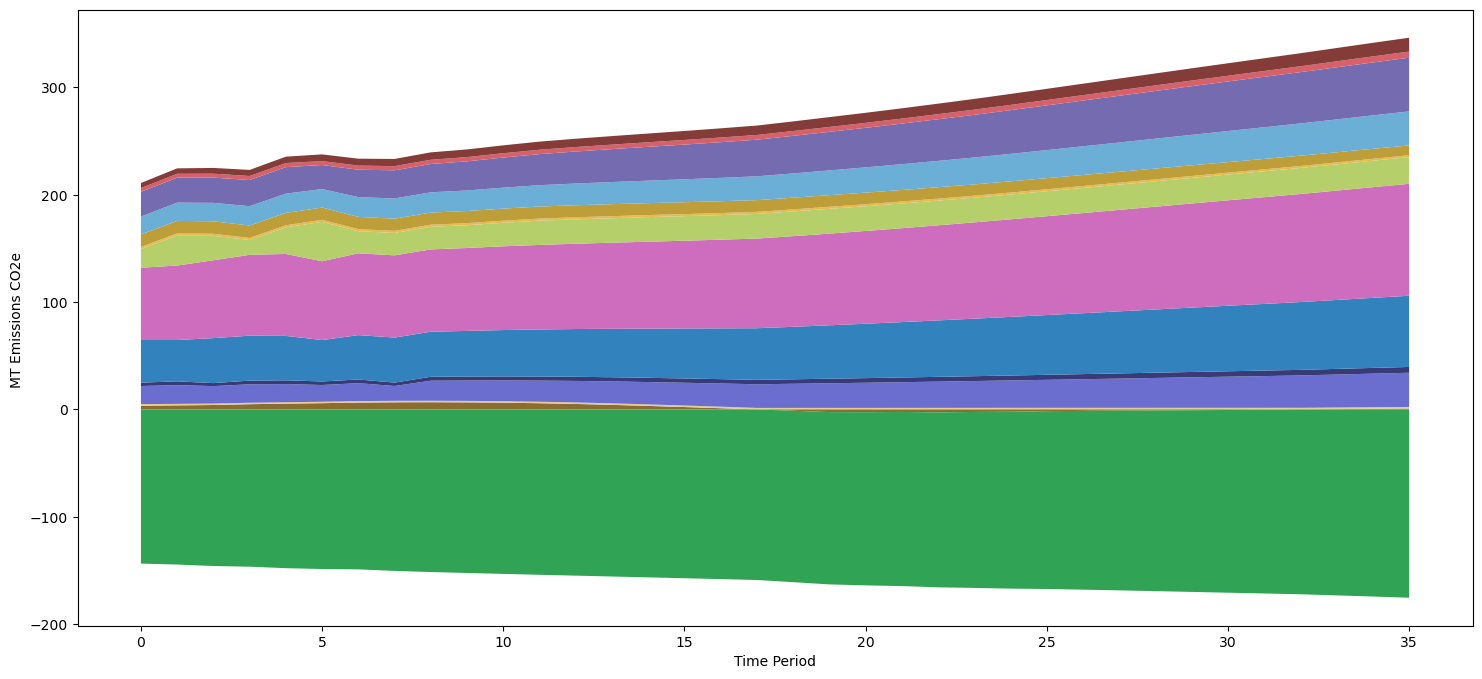

In [70]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)


# Export Wide File (Last Mandatory Step)

In [71]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [72]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/opt/miniconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/out'

## Some Optional Plotting

In [73]:
# primary_id = 0

# df_prim = df_out[
#     df_out[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]

# df_in_cur = df_in[
#     df_in[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]


# fields_plot = [
#     x for x in df_prim.columns
#     if "investment" in x
#     and df_prim[x].max() > 0
# ]
# (
#     df_prim[fields_plot]
#     .plot(
#         legend = True,
#     )
# )




In [ ]:


# fig, ax = plt.subplots(figsize = (15, 10))
# df_resid = matt.extract_model_variable(
#     df_in_cur,
#     "NemoMod ResidualCapacity"
# )
# (
#     df_resid
#     .plot
#     .area(
#         ax = ax
#     )
# )

In [ ]:
# df_resid

In [ ]:
# [x for x in df_out.columns if "capacity" in x]

In [ ]:
# ssp.model_attributes.configuration.dict_config


In [ ]:
# modvar = matt.get_variable("NemoMod Generation Capacity")
# modvar.get_from_dataframe(df_prim).head()

In [ ]:
# #[x for x in matt.all_variables if "Consumption" in x]
# [x for x in matt.all_variables if "Production" in x]
# modvar = matt.get_variable("NemoMod Production by Technology")


# unit = matt.get_unit("energy")
# (modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

In [ ]:
# df_inputs

In [ ]:
# modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
# matt.extract_model_variable(
#     df_prim,
#     modvar
# )